## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. <br/>
В нём можно быстро узнать рыночную стоимость своего автомобиля. 

В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.<br/>
Вам нужно построить модель для определения стоимости.<br/>
Заказчику важны:
- качество предсказания;
- скорость предсказания;
- время обучения.

Инструкция по выполнению проекта

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.

1. Загрузите и подготовьте данные.
    - Импортируем библиотеки [тут](#step1.1)
    - Загружаем данные [тут](#step1.2)
    - Изучаем данные [тут](#step1.3)
    - Смотрим на распределение данных [тут](#step1.4)
    - Строим план предобработки [тут](#step1.5)
<br/>


2. Предобработка данных [тут](#step2)<br/>

3. [Обучение моделей](#step3)
    - CatBoost на непреобразованных данных [тут](#step3.1)
    - One-Hot Encoding [тут](#step3.2)
    - LightGBM [тут](#step3.3)
        - GridSearchCV для LightGBM [тут](#step3.3.1)
        - Обучение LightGBM [тут](#step3.3.2)
    - LinearRegression [тут](#step3.4)
    - CatBoost на преобразованных данных [тут](#step3.1)

4. [Итоги.](#step4)

## Описание данных

Признаки:

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

#### Импортируем необходимые библиотеки<a id="step1.1"></a>

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
pd.set_option('display.precision',3)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

#### Загрузка данных<a id="step1.2"></a>

In [4]:
try:
    
    base = pd.read_csv(
        'C:/Users/timur/Я.Практикум/Проекты/Data Science/finished/11.Предсказание цены автомобиля/autos.csv')
    
except:
    
    base = pd.read_csv('/datasets/autos.csv')

#### Предпросмотр данных<a id="step1.3"></a>

In [5]:
base.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [6]:
base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Необходимо обработать признаки с типом object

#### Пропуски

In [7]:
base.isna().mean().sort_values(ascending=False)

NotRepaired          0.201
VehicleType          0.106
FuelType             0.093
Gearbox              0.056
Model                0.056
LastSeen             0.000
PostalCode           0.000
NumberOfPictures     0.000
DateCreated          0.000
Brand                0.000
RegistrationMonth    0.000
Kilometer            0.000
Power                0.000
RegistrationYear     0.000
Price                0.000
DateCrawled          0.000
dtype: float64

Дубликаты

In [8]:
base.duplicated().sum()

4

In [9]:
base[base.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Временной промежуток наблюдений

In [10]:
base['DateCreated'].min()

'2014-03-10 00:00:00'

In [11]:
base['DateCreated'].max()

'2016-04-07 00:00:00'

Корреляция

In [12]:
base.corr()['Price'].sort_values(ascending=False)

Price                1.000
Power                0.159
RegistrationMonth    0.111
PostalCode           0.076
RegistrationYear     0.027
Kilometer           -0.333
NumberOfPictures       NaN
Name: Price, dtype: float64

#### Распределение данных <a id="step1.4"></a>

In [13]:
for i in base.columns:
    print()
    print(base[i].value_counts())
    print()


2016-03-24 14:49:47    7
2016-03-26 22:57:31    6
2016-03-19 21:49:56    6
2016-04-01 19:25:23    5
2016-03-19 12:50:39    5
                      ..
2016-03-22 19:36:24    1
2016-03-28 16:52:53    1
2016-03-29 15:36:45    1
2016-03-12 17:38:58    1
2016-03-31 17:53:58    1
Name: DateCrawled, Length: 271174, dtype: int64


0        10772
500       5670
1500      5394
1000      4649
1200      4594
         ...  
13440        1
1414         1
8069         1
10370        1
384          1
Name: Price, Length: 3731, dtype: int64


sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64


2000    24490
1999    22728
2005    22109
2001    20124
2006    19900
        ...  
3200        1
1920        1
1919        1
1915        1
8455        1
Name: RegistrationYear, Length: 151, dtype: int64


manual    268251
auto       66285
Name: Gearbox, dtype: int

### Распределение количества автомобилей и цен

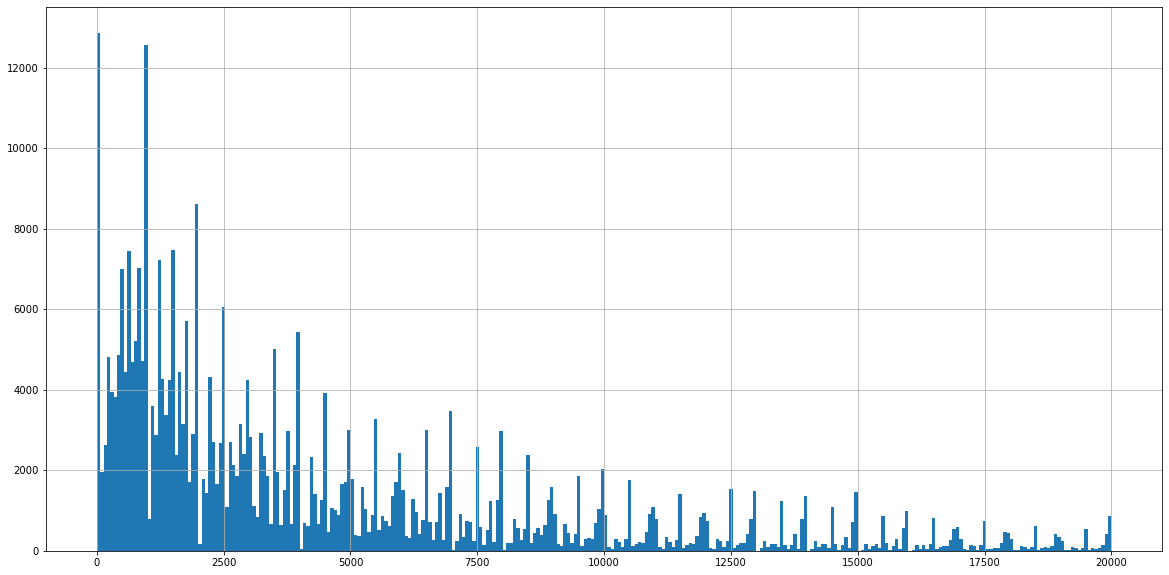

In [14]:
plt.figure(figsize=(20,10))
base['Price'].hist(bins=300)

### Распределение количества автомобилей и мощности (мощность менее 500лс)

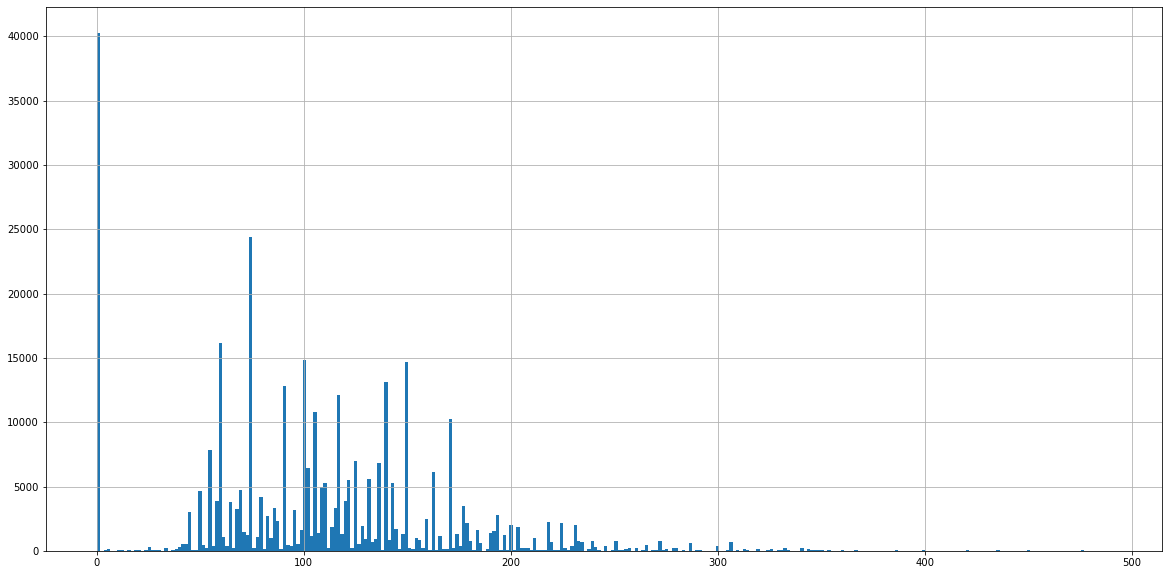

In [15]:
plt.figure(figsize=(20,10))
base[base['Power'] < 500]['Power'].hist(bins=300)

### Распределение количества автомобилей и моделей

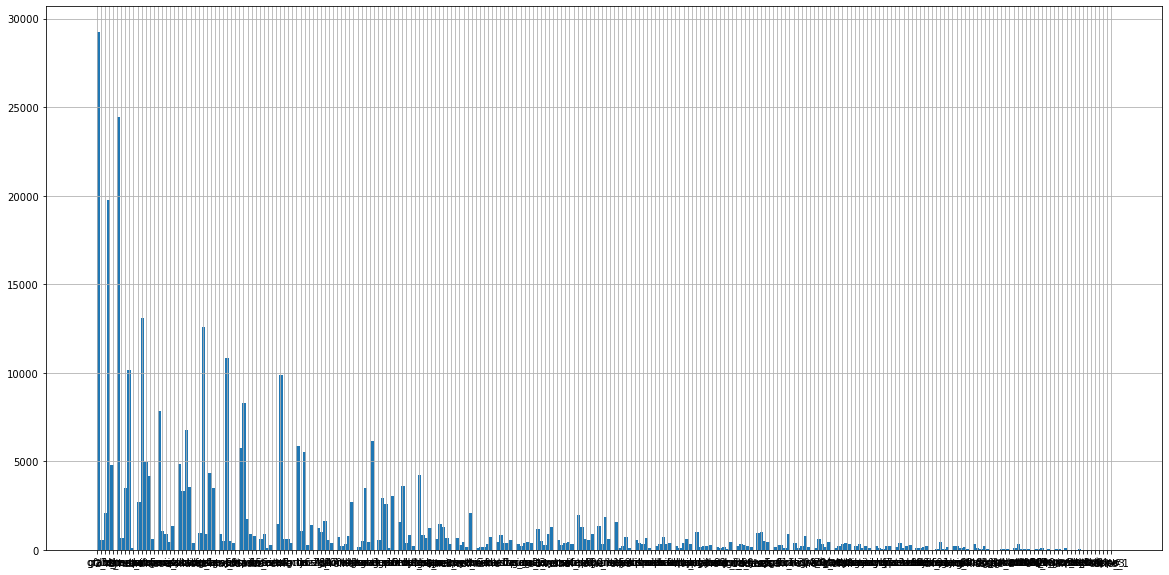

In [16]:
plt.figure(figsize=(20,10))
base['Model'].hist(bins=300)

Итоги первичного осмотра пациента: <a id="step1.5"></a>
1. 'DateCrawled' - фича не содержащая какой-то полезной интформации, удалим полностью;
- 'Price' - 10772 пустых значений в целевом признаке, эти объекты удалим; кроме того, много объектов цена в которых 0-100$, такие объекты тоже нужно удалить;
- 'VehicleType' - много пропусков; категориальный признак, имеет тип object, нужно применить OHE;  
- 'RegistrationYear' - наличие выбросов, нужно ограничить период;
- 'Gearbox' - пропуски; категориальный признак, имеет тип object, нужно применить OHE;
- 'Power' - наличие выбросов, нужно выбрать потолок мощности; кроме того, много нулевых значений;
- 'Model' - много выбросов, предложить заказчику сделать поле на сервисе категориальным, чтобы пользователи не писали ерунду; можно лемматизировать, но трудозатратно;
- 'Kilometer' - никаких претензий;
- 'RegistrationMonth' - есть нулевой месяц, но это не должно как-то сильно повлиять;
- 'FuelType' - есть пропуски, можно попробовать залить бензином, либо оставить без изменений; признак категориальный, нужно поменять тип и применить OHE;
- 'Brand' - никаких претензий;
- 'NotRepaired' - много пропусков, нужно сравнить 2 варианта: заменить на 'no', либо выделить в отдельную категорию; ну и заменить 'no' на 0, а 'yes' на 1, можно и без OHE;
- 'DateCreated' - фича выглядит бесполезной, удалим;
- 'NumberOfPictures' - признак полностью состоит из нулей, удалим столбец целиком;
- 'PostalCode' - кажется бесполезным, да и с выбросами; сравним показатели с этим признаком и без него, если окажется полезным - можно попробовать предобработать;
- 'LastSeen' - непонятно, какую пользу модель может получить из этой информации; удалим признак;

### Предобработка данных <a id="step2"></a>

Соберем рабочий датафрейм, без следующих признаков: DateCrawled, NumberOfPictures, LastSeen, PostalCode, DateCreated.

In [17]:
base[base['PostalCode']<10000]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
14,2016-03-21 12:57:01,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no,2016-03-21 00:00:00,0,4177,2016-04-06 07:45:42
23,2016-03-12 19:43:07,450,small,1997,manual,50,arosa,150000,5,petrol,seat,no,2016-03-12 00:00:00,0,9526,2016-03-21 01:46:11
36,2016-03-11 11:50:37,1600,other,1991,manual,75,kadett,70000,0,NaN,opel,NaN,2016-03-11 00:00:00,0,2943,2016-04-07 03:46:09
63,2016-03-08 12:54:47,7000,sedan,2006,auto,105,jetta,100000,10,gasoline,volkswagen,no,2016-03-08 00:00:00,0,6242,2016-03-11 17:16:18
64,2016-03-07 22:36:54,14999,convertible,2007,manual,218,3er,50000,8,petrol,bmw,no,2016-03-07 00:00:00,0,1129,2016-03-15 10:17:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354311,2016-03-08 20:43:20,3000,sedan,2006,manual,105,golf,150000,6,gasoline,volkswagen,no,2016-03-08 00:00:00,0,1217,2016-03-08 20:43:20
354337,2016-03-26 14:38:18,11500,sedan,2004,auto,445,7er,125000,0,petrol,bmw,NaN,2016-03-26 00:00:00,0,4107,2016-04-06 20:45:16
354348,2016-03-20 18:47:59,5900,sedan,2006,manual,105,golf,150000,9,gasoline,volkswagen,no,2016-03-20 00:00:00,0,1217,2016-04-07 02:44:27
354353,2016-03-31 18:50:37,1999,sedan,1997,manual,150,a3,150000,12,petrol,audi,no,2016-03-31 00:00:00,0,4275,2016-04-06 12:46:41


In [18]:
base.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [19]:
df = base[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired']]

Удалим объекты в которых целевой признак менее 100 долларов. 

In [20]:
df = df[df['Price']>=100]

In [21]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


Предже чем применять метод OHE нужно разобраться с пропусками в категориальных переменных, иначе NaN'ы сольются с первой колонкой после drop_first

В столбце VehicleType заменим отсутствующие значения на unknown.

In [22]:
df['VehicleType'].value_counts()

sedan          89087
small          77444
wagon          63465
bus            28265
convertible    19817
coupe          15555
suv            11762
other           3048
Name: VehicleType, dtype: int64

In [23]:
df['VehicleType'] = df['VehicleType'].fillna(value='unknown')

In [24]:
df['VehicleType'].isna().sum()

0

Таргет ограничим сотней долларов, меньше - выбросы и NaN'ы

In [25]:
df = df[df['Price']>=100]

Посмотрим, сколько потеряем объектов, если ограничим год выпуска автомобилей премежутком 1970 - 2016.

Экземпляры старше - уже настоящий раритет, сильно зависят от состояния, труднопрогнозируемы.

Моложе - выбросы, ведь дата последней публикации - 2016-04-07 00:00:00.

In [26]:
1 - len(df[(df['RegistrationYear']>=1970) & (df['RegistrationYear']<=2016)]) / len(df)

0.04340355661110373

4%, не такая большая плата, учитывая, что данных много.

In [27]:
df = df[(df['RegistrationYear']>=1970) & (df['RegistrationYear']<=2016)]

В Gearbox заменим отсутствующие значения на unknown.

In [28]:
df['Gearbox'] = df['Gearbox'].fillna(value='unknown')

В Power попробуем найти границу, за которой только гарантированные выбросы.

In [29]:
df['Power'].describe()

count    326252.000
mean        112.436
std         183.364
min           0.000
25%          72.000
50%         105.000
75%         143.000
max       20000.000
Name: Power, dtype: float64

In [30]:
len(df[df['Power']>500])

384

In [31]:
df[df['Power']>500]['Model'].value_counts()

other       32
golf        19
polo        15
3er         15
corsa       14
            ..
escort       1
seicento     1
nubira       1
c4           1
megane       1
Name: Model, Length: 92, dtype: int64

In [32]:
df[(df['Power']>500) & (df['Model']=='other')]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
23173,400,unknown,2015,auto,610,other,5000,1,NaN,audi,NaN
23188,11999,wagon,2002,auto,504,other,150000,12,petrol,audi,no
32784,9500,bus,1986,auto,1659,other,40000,12,petrol,chevrolet,no
53953,550,small,2000,manual,1360,other,150000,1,petrol,citroen,yes
73749,18500,sedan,2012,auto,520,other,50000,0,petrol,audi,yes
92226,950,small,2001,manual,8404,other,125000,7,petrol,suzuki,NaN
102613,19500,coupe,1974,auto,600,other,5000,7,petrol,chevrolet,no
105658,19000,wagon,2008,auto,579,other,150000,3,petrol,audi,yes
119692,3000,small,2013,manual,1000,other,150000,0,petrol,ford,yes
124348,19999,sedan,2005,unknown,550,other,150000,6,NaN,mercedes_benz,no


500 лс - приемлемая граница отсечки.

In [33]:
df = df[df['Power']<=500]

'Model', 'FuelType', 'NotRepaired' заменим NaN'ы на unknown.

In [34]:
df['Model'] = df['Model'].fillna(value='unknown')
df['FuelType'] = df['FuelType'].fillna(value='unknown')
df['NotRepaired'] = df['NotRepaired'].fillna(value='unknown')

In [35]:
df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
dtype: int64

In [36]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,0,golf,150000,0,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no
354365,2200,unknown,2005,unknown,0,unknown,20000,1,unknown,sonstige_autos,unknown
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no


In [37]:
df.dtypes

Price                 int64
VehicleType          object
RegistrationYear      int64
Gearbox              object
Power                 int64
Model                object
Kilometer             int64
RegistrationMonth     int64
FuelType             object
Brand                object
NotRepaired          object
dtype: object

## Обучение моделей <a id="step3"></a>

Обучение начнем с CatBoost'а, он не требует преобразования категориальных признаков.<br/>
Затем преобразуем признаки мотодом OHE. На преобразованных данных обучим LightGBM и LinearRegression. <br/>
Для интереса, CatBoost попробуем обучить на преобразованных данных тоже. <br/>
Сравним показатели RMSE и времени.

In [38]:
features_defolt = ['VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired']
target_defolt = ['Price']
cat_features = ['VehicleType', 'Gearbox',
       'Model', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired']

In [39]:
train_defolt = df.sample(frac=0.6, random_state=42).copy()

val_defolt = df[~df.index.isin(train_defolt.index)].sample(frac=0.5, random_state=42).copy()

test_defolt = df[(~df.index.isin(train_defolt.index))&(~df.index.isin(val_defolt.index))]

In [40]:
len(df)

325868

In [41]:
len(train_defolt) + len (val_defolt) + len(test_defolt)

325868

### CatBoost на непреобразованных данных  <a id="step3.1"></a>

In [42]:
!pip install catboost

In [43]:
from catboost import CatBoostRegressor

In [44]:
start_time = time.time()

model = CatBoostRegressor(verbose=100, eval_metric='RMSE', cat_features=cat_features)
model.fit(train_defolt[features_defolt], train_defolt[target_defolt],
          eval_set=(val_defolt[features_defolt], val_defolt[target_defolt]))
learn_time = time.time() - start_time

Learning rate set to 0.124889
0:	learn: 4166.9159195	test: 4171.4800654	best: 4171.4800654 (0)	total: 365ms	remaining: 6m 4s
100:	learn: 1707.5670402	test: 1732.3749796	best: 1732.3749796 (100)	total: 16.3s	remaining: 2m 25s
200:	learn: 1632.9500864	test: 1666.4165642	best: 1666.4165642 (200)	total: 31.5s	remaining: 2m 5s
300:	learn: 1597.3843037	test: 1641.1969631	best: 1641.1969631 (300)	total: 46.9s	remaining: 1m 48s
400:	learn: 1574.0307192	test: 1628.3895407	best: 1628.3895407 (400)	total: 1m 2s	remaining: 1m 33s
500:	learn: 1556.9568310	test: 1618.4736692	best: 1618.4736692 (500)	total: 1m 17s	remaining: 1m 16s
600:	learn: 1540.9012927	test: 1608.4959747	best: 1608.4849469 (599)	total: 1m 32s	remaining: 1m 1s
700:	learn: 1524.9715536	test: 1599.3283262	best: 1599.3283262 (700)	total: 1m 48s	remaining: 46.4s
800:	learn: 1514.2989267	test: 1594.8626706	best: 1594.8626706 (800)	total: 2m 3s	remaining: 30.8s
900:	learn: 1504.6727745	test: 1590.8744956	best: 1590.8744956 (900)	total: 

In [45]:
features_weight = pd.DataFrame({'name':features_defolt,'weight':model.feature_importances_}).sort_values('weight', ascending=False)

In [46]:
features_weight

,name,weight
1,RegistrationYear,38.527
3,Power,21.013
0,VehicleType,12.241
5,Kilometer,9.362
8,Brand,8.594
4,Model,4.421
9,NotRepaired,2.865
7,FuelType,1.627
2,Gearbox,0.962
6,RegistrationMonth,0.388


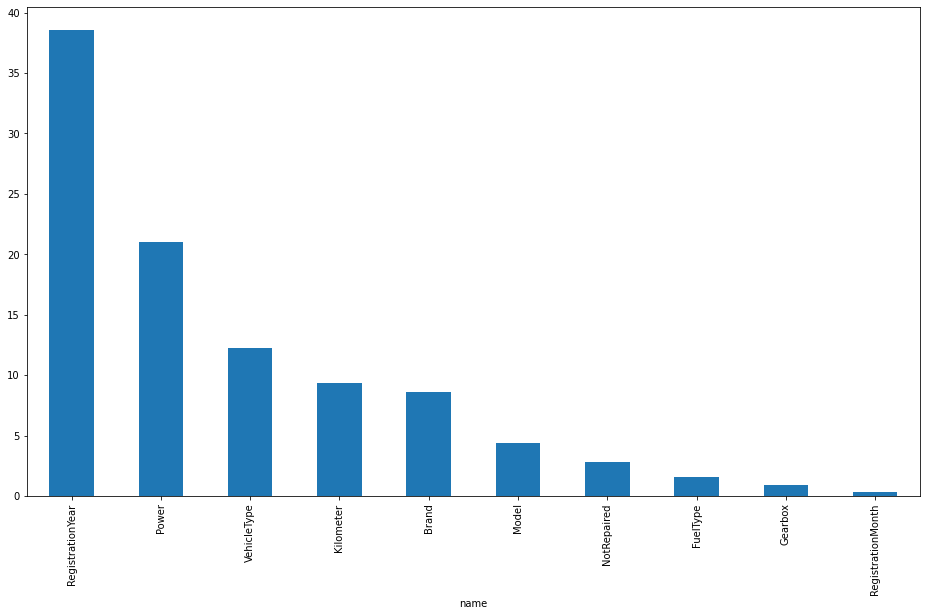

In [47]:
features_weight.set_index('name')['weight'].plot(kind='bar', figsize=(16, 9))

In [48]:
start_time = time.time()
pred = model.predict(test_defolt[features_defolt])
pred_time = time.time() - start_time
rmse = mean_squared_error(pred, test_defolt[target_defolt]) ** 0.5
print('RMSE =', rmse)
print('Время затраченное на обучение -', learn_time, 'секунд')
print('Время затраченное на предсказание -', pred_time, 'секунд')

RMSE = 1580.7334857670296
Время затраченное на обучение - 157.50357484817505 секунд
Время затраченное на предсказание - 0.28801584243774414 секунд


In [49]:
Name = ['Cat_Defolt']
RMSE = [rmse]
Learn_Time = [learn_time]
Pred_Time = [pred_time]

### OHE  <a id="step3.2"></a>

In [50]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [51]:
df_ohe.columns

Index(['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth',
       'VehicleType_convertible', 'VehicleType_coupe', 'VehicleType_other',
       'VehicleType_sedan', 'VehicleType_small',
       ...
       'Brand_smart', 'Brand_sonstige_autos', 'Brand_subaru', 'Brand_suzuki',
       'Brand_toyota', 'Brand_trabant', 'Brand_volkswagen', 'Brand_volvo',
       'NotRepaired_unknown', 'NotRepaired_yes'],
      dtype='object', length=313)

In [52]:
features_ohe = df_ohe.columns.drop(['Price'])
target_ohe = ['Price']

In [53]:
train_ohe = df_ohe.sample(frac=0.6, random_state=42).copy()

val_ohe = df_ohe[~df_ohe.index.isin(train_defolt.index)].sample(frac=0.5, random_state=42).copy()

test_ohe = df_ohe[(~df_ohe.index.isin(train_ohe.index))&(~df_ohe.index.isin(val_ohe.index))]

### LightGBM

In [54]:
!pip install lightgbm

In [55]:
from lightgbm import LGBMRegressor

#### GridSearchCV для LightGBM

In [56]:
from sklearn.model_selection import GridSearchCV

In [57]:
model = LGBMRegressor()

param = {'num_leaves': [250, 500, 750, 1000],
         'max_depth': range (1,13, 2),
         'learning_rate': [0.01, 0.05, 0.1, 0.25]}

start_time = time.time()
grid = GridSearchCV(model, param, scoring='neg_root_mean_squared_error', cv=5)
grid.fit(train_ohe[features_ohe],  train_ohe[target_ohe])
final_time = time.time()

grid.best_params_

{'learning_rate': 0.25, 'max_depth': 11, 'num_leaves': 1000}

In [58]:
print('Время подбора гиперпараметров для LightGBM составило -', final_time - start_time, 'секунд')

Время подбора гиперпараметров для LightGBM составило - 827.2212390899658 секунд


In [59]:
start_time = time.time()
model = LGBMRegressor(learning_rate=0.25, max_depth=11, n_estimators=1000, num_leaves=1000, metric = 'rmse', early_stopping_round=100)

model.fit(train_ohe[features_ohe], train_ohe[target_ohe],
          eval_set=(val_ohe[features_ohe], val_ohe[target_ohe]))

learn_time = time.time() - start_time

[1]	valid_0's rmse: 3635.63
Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 3002.28
[3]	valid_0's rmse: 2562.09
[4]	valid_0's rmse: 2263.54
[5]	valid_0's rmse: 2063.41
[6]	valid_0's rmse: 1930.28
[7]	valid_0's rmse: 1843.15
[8]	valid_0's rmse: 1781.25
[9]	valid_0's rmse: 1741.76
[10]	valid_0's rmse: 1712.6
[11]	valid_0's rmse: 1695.34
[12]	valid_0's rmse: 1677.87
[13]	valid_0's rmse: 1666.21
[14]	valid_0's rmse: 1655.63
[15]	valid_0's rmse: 1647.5
[16]	valid_0's rmse: 1641.52
[17]	valid_0's rmse: 1638.12
[18]	valid_0's rmse: 1633.3
[19]	valid_0's rmse: 1628.95
[20]	valid_0's rmse: 1626.95
[21]	valid_0's rmse: 1623.9
[22]	valid_0's rmse: 1621.24
[23]	valid_0's rmse: 1618.89
[24]	valid_0's rmse: 1617.05
[25]	valid_0's rmse: 1614.86
[26]	valid_0's rmse: 1613.12
[27]	valid_0's rmse: 1612.2
[28]	valid_0's rmse: 1611.44
[29]	valid_0's rmse: 1609.6
[30]	valid_0's rmse: 1608.62
[31]	valid_0's rmse: 1606.81
[32]	valid_0's rmse: 1605.7
[33]	valid_0's rmse: 1605.

[296]	valid_0's rmse: 1551.09
[297]	valid_0's rmse: 1550.98
[298]	valid_0's rmse: 1550.91
[299]	valid_0's rmse: 1550.89
[300]	valid_0's rmse: 1550.89
[301]	valid_0's rmse: 1550.87
[302]	valid_0's rmse: 1550.77
[303]	valid_0's rmse: 1550.84
[304]	valid_0's rmse: 1550.79
[305]	valid_0's rmse: 1550.6
[306]	valid_0's rmse: 1550.65
[307]	valid_0's rmse: 1550.65
[308]	valid_0's rmse: 1550.63
[309]	valid_0's rmse: 1550.64
[310]	valid_0's rmse: 1550.62
[311]	valid_0's rmse: 1550.71
[312]	valid_0's rmse: 1550.65
[313]	valid_0's rmse: 1550.63
[314]	valid_0's rmse: 1550.49
[315]	valid_0's rmse: 1550.33
[316]	valid_0's rmse: 1550.22
[317]	valid_0's rmse: 1550.16
[318]	valid_0's rmse: 1550.19
[319]	valid_0's rmse: 1550.17
[320]	valid_0's rmse: 1550.32
[321]	valid_0's rmse: 1550.17
[322]	valid_0's rmse: 1550.27
[323]	valid_0's rmse: 1550.33
[324]	valid_0's rmse: 1550.41
[325]	valid_0's rmse: 1550.42
[326]	valid_0's rmse: 1550.25
[327]	valid_0's rmse: 1550.27
[328]	valid_0's rmse: 1550.24
[329]	valid

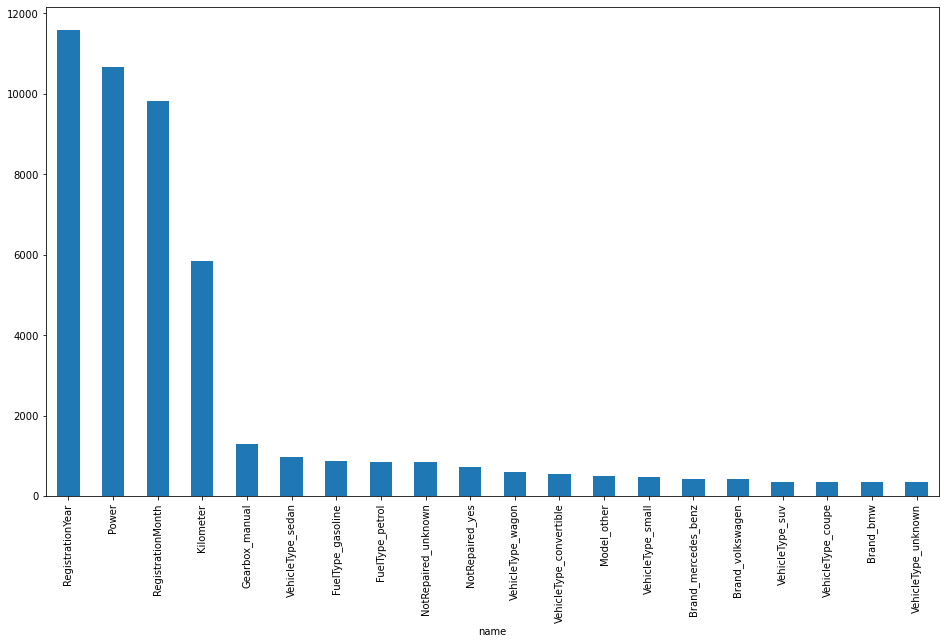

In [60]:
features_weight = pd.DataFrame({'name':features_ohe,'weight':model.feature_importances_}).sort_values('weight', ascending=False).head(20)

features_weight.set_index('name')['weight'].plot(kind='bar', figsize=(16, 9))

In [61]:
start_time = time.time()
pred = model.predict(test_ohe[features_ohe])
pred_time = time.time() - start_time
rmse = mean_squared_error(pred, test_ohe[target_ohe]) ** 0.5
print('RMSE на тестовой выборке =', rmse)
print('Время затраченное на обучение -', learn_time, 'секунд')
print('Время затраченное на предсказание -', pred_time, 'секунд')

RMSE на тестовой выборке = 1539.4803529167534
Время затраченное на обучение - 6.448233604431152 секунд
Время затраченное на предсказание - 1.0726242065429688 секунд


In [62]:
Name.append('LightGBM')
RMSE.append(rmse)
Learn_Time.append(learn_time)
Pred_Time.append(pred_time)

### Линейная регрессия

In [63]:
start_time = time.time()
model_lr = LinearRegression()
model_lr.fit(train_ohe[features_ohe],  train_ohe[target_ohe])
learn_time = time.time() - start_time
start_time = time.time()
pred = model_lr.predict(test_ohe[features_ohe])
pred_time = time.time() - start_time
rmse = mean_squared_error(pred, test_ohe[target_ohe]) ** 0.5
print('RMSE на тестовой выборке =', rmse)
print('Время затраченное на обучение модели LinearRegression -', learn_time,'секунд')

RMSE на тестовой выборке = 2600.6429245556874
Время затраченное на обучение модели LinearRegression - 2.351700782775879 секунд


In [64]:
Name.append('LinearRegression')
RMSE.append(rmse)
Learn_Time.append(learn_time)
Pred_Time.append(pred_time)

### CatBoost на преобразованных данных

In [65]:
start_time = time.time()

model = CatBoostRegressor(verbose=100, eval_metric='RMSE')
model.fit(train_ohe[features_ohe], train_ohe[target_ohe],
          eval_set=(val_ohe[features_ohe], val_ohe[target_ohe]))
learn_time = time.time() - start_time

Learning rate set to 0.124889
0:	learn: 4179.0792753	test: 4184.6290922	best: 4184.6290922 (0)	total: 28.4ms	remaining: 28.4s
100:	learn: 1760.5618703	test: 1789.0223523	best: 1789.0223523 (100)	total: 1.82s	remaining: 16.2s
200:	learn: 1667.8584819	test: 1704.4325618	best: 1704.4325618 (200)	total: 3.6s	remaining: 14.3s
300:	learn: 1618.8820871	test: 1664.3410463	best: 1664.3410463 (300)	total: 5.34s	remaining: 12.4s
400:	learn: 1584.6169635	test: 1638.5478699	best: 1638.5478699 (400)	total: 7.08s	remaining: 10.6s
500:	learn: 1558.7975795	test: 1620.8775122	best: 1620.8775122 (500)	total: 8.82s	remaining: 8.79s
600:	learn: 1537.4787322	test: 1606.7128190	best: 1606.7128190 (600)	total: 10.6s	remaining: 7.01s
700:	learn: 1519.7872100	test: 1598.0463453	best: 1598.0463453 (700)	total: 12.3s	remaining: 5.25s
800:	learn: 1505.0486084	test: 1590.2941150	best: 1590.2941150 (800)	total: 14.1s	remaining: 3.49s
900:	learn: 1492.2606603	test: 1583.9380865	best: 1583.9380865 (900)	total: 15.8s	r

In [66]:
pd.DataFrame({'name':features_ohe,'weight':model.feature_importances_}).sort_values('weight', ascending=False).head(10)

,name,weight
0,RegistrationYear,36.584
1,Power,26.338
2,Kilometer,10.294
10,VehicleType_unknown,2.765
4,VehicleType_convertible,2.249
311,NotRepaired_yes,2.036
265,FuelType_gasoline,1.854
290,Brand_mercedes_benz,1.797
271,Brand_audi,1.712
272,Brand_bmw,1.635


In [67]:
start_time = time.time()
pred = model.predict(test_ohe[features_ohe])
pred_time = time.time() - start_time
rmse = mean_squared_error(pred, test_ohe[target_ohe]) ** 0.5
print('RMSE на тестовой выборке =', rmse)
print('Время затраченное на обучение модели CatBoost -', learn_time, 'секунд')

RMSE на тестовой выборке = 1568.7274197162883
Время затраченное на обучение модели CatBoost - 18.667577266693115 секунд


### Наиболее важные признаки

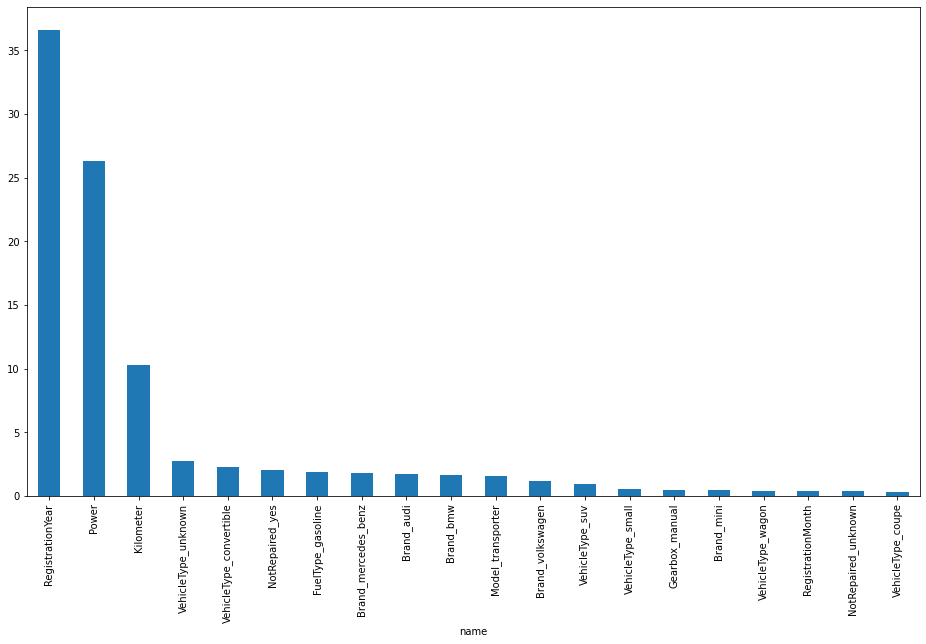

In [68]:
features_weight = pd.DataFrame({'name':features_ohe,'weight':model.feature_importances_}).sort_values('weight', ascending=False).head(20)

features_weight.set_index('name')['weight'].plot(kind='bar', figsize=(16, 9))

In [69]:
Name.append('CatOHE')
RMSE.append(rmse)
Learn_Time.append(learn_time)
Pred_Time.append(pred_time)

In [70]:
final_table = pd.DataFrame([RMSE, Learn_Time, Pred_Time]).T

final_table.columns = ['RMSE','Learn_time','Pred_time']
final_table.index = Name

Сводные показатели:
 - CatBoost на непреобразованных данных: RMSE - 1580.73, время обучения - 157.88 секунд;
 - LightGBM после GridSearchCV и OHE: RMSE - 1539.48, время обучения(без учета времени подбора оптимальных параметров) - 2.08 секунд;
 - Линейная регрессия после OHE: RMSE - 2600.64, время обучения - 2.71 секунды;
 - CatBoost после GridSearchCV и OHE: RMSE - 1568.72, время обучения - 19.41 секунд.
 
1. Градиентные модели существенно выигрывают по метрике в данной задаче. <br/>
2. Cat показал хорошие результаты без дополнительного подбора гиперпараметров, несущественно хуже чем LightGBM после GridSearchCV.<br/>
3. После преобразования категориальных параметров методом OneHot Encoding качество CatBoost'а немного улучшилось.<br/>
4. LightGBM лидировал с минимальным RMSE 1540.00 на тестовых данных и временем обучения модели 2.08 секунды.

In [71]:
final_table

,RMSE,Learn_time,Pred_time
Cat_Defolt,1580.733,157.504,0.288
LightGBM,1539.480,6.448,1.073
LinearRegression,2600.643,2.352,0.176
CatOHE,1568.727,18.668,0.064


Требуется уточнить у заказчика, что считать приемлемыми показателями по качеству и времени обучения, прежде чем дать однозначный ответ.

Но выбирать будем между LightGBM и CatBoost, прогнав их предварительно через GridSearchCV.

Наиболее значимые признаки для определения цены автомобиля: год регистрации, тип кузова, мощность, пробег, брэнд.